Final Project Submission
Please fill out:

Student name: Zach Paul
Student pace: Part time
Scheduled project review date/time: 11/30
Instructor name: Amber Yandow
Blog post URL:

The purpose of this project is to accurately predict if a customer will quit using a telecommunications provider based on their customer stats, so that the provider can do something about the customer potentially leaving to retain the customer.
Dataset comes from https://www.kaggle.com/blastchar/telco-customer-churn

Import packages for use. 

In [53]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

Read in the csv and display the head. 

In [54]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Look through the data, check for missing values or placeholder values. 

In [55]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Totalcharges should be a float. 

In [56]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') #there are actually missing values in here,
                                                                        #convert them to NA, then convert them to 0.
df['TotalCharges'] = df['TotalCharges'].fillna(0)
#df['TotalCharges'][470:500]

In [57]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [58]:
for col in df.columns:
    print(df[col].value_counts())

1036-GUDCL    1
5590-BYNII    1
6173-ITPWD    1
8775-LHDJH    1
6351-SCJKT    1
             ..
3745-HRPHI    1
9412-GHEEC    1
0307-BCOPK    1
9483-GCPWE    1
9577-WJVCQ    1
Name: customerID, Length: 7043, dtype: int64
Male      3555
Female    3488
Name: gender, dtype: int64
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64
Yes    6361
No      682
Name: PhoneService, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
No                     3088
Yes

Don't see any missing values, or any placeholder values. Everything looks OK.

Look at the distribution of the target variable.


In [59]:
target = df['Churn'].map({'Yes' : 1, 'No' : 0})
features = df.drop(['Churn', 'customerID'], axis=1)
print(target.value_counts(normalize=True))

0    0.73463
1    0.26537
Name: Churn, dtype: float64


In [60]:
features.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [61]:
features.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


Phoneservice and multiple lines contains redundant information, can remove phone service entirely probably.
Should be some way to combine internet service, online security and online backup
Streaming combined? 

In [62]:
features.groupby(['PhoneService', 'MultipleLines']).count()

gender  SeniorCitizen  Partner  Dependents  \
PhoneService MultipleLines                                                  
No           No phone service     682            682      682         682   
Yes          No                  3390           3390     3390        3390   
             Yes                 2971           2971     2971        2971   

                               tenure  InternetService  OnlineSecurity  \
PhoneService MultipleLines                                               
No           No phone service     682              682             682   
Yes          No                  3390             3390            3390   
             Yes                 2971             2971            2971   

                               OnlineBackup  DeviceProtection  TechSupport  \
PhoneService MultipleLines                                                   
No           No phone service           682               682          682   
Yes          No                        3390              3390         3390   
             Yes                       2971              2971         2971   

                               StreamingTV  StreamingMovies  Contract  \
PhoneService MultipleLines                                              
No           No phone service          682              682       682   
Yes          No                       3390             3390      3390   
             Yes                      2971             2971      2971   

                               PaperlessBilling  PaymentMethod  \
PhoneService MultipleLines                                       
No           No phone service               682            682   
Yes          No                            3390           3390   
             Yes                           2971           2971   

                               MonthlyCharges  TotalCharges  
PhoneService MultipleLines                                   
No           No phone service             682           682  
Yes          No                          3390          3390  
             Yes                         2971          2971

Phoneservice can be dropped.

In [63]:
features.groupby(['InternetService', 'OnlineSecurity', 'OnlineBackup']).count()

gender  \
InternetService OnlineSecurity      OnlineBackup                  
DSL             No                  No                      792   
                                    Yes                     449   
                Yes                 No                      543   
                                    Yes                     637   
Fiber optic     No                  No                     1403   
                                    Yes                     854   
                Yes                 No                      350   
                                    Yes                     489   
No              No internet service No internet service    1526   

                                                         SeniorCitizen  \
InternetService OnlineSecurity      OnlineBackup                         
DSL             No                  No                             792   
                                    Yes                            449   
                Yes                 No                             543   
                                    Yes                            637   
Fiber optic     No                  No                            1403   
                                    Yes                            854   
                Yes                 No                             350   
                                    Yes                            489   
No              No internet service No internet service           1526   

                                                         Partner  Dependents  \
InternetService OnlineSecurity      OnlineBackup                               
DSL             No                  No                       792         792   
                                    Yes                      449         449   
                Yes                 No                       543         543   
                                    Yes                      637         637   
Fiber optic     No                  No                      1403        1403   
                                    Yes                      854         854   
                Yes                 No                       350         350   
                                    Yes                      489         489   
No              No internet service No internet service     1526        1526   

                                                         tenure  PhoneService  \
InternetService OnlineSecurity      OnlineBackup                                
DSL             No                  No                      792           792   
                                    Yes                     449           449   
                Yes                 No                      543           543   
                                    Yes                     637           637   
Fiber optic     No                  No                     1403          1403   
                                    Yes                     854           854   
                Yes                 No                      350           350   
                                    Yes                     489           489   
No              No internet service No internet service    1526          1526   

                                                         MultipleLines  \
InternetService OnlineSecurity      OnlineBackup                         
DSL             No                  No                             792   
                                    Yes                            449   
                Yes                 No                             543   
                                    Yes                            637   
Fiber optic     No                  No                            1403   
                                    Yes                            854   
                Yes                 No                             350   
                                    Yes                          

Doesn't look like internet service and online security can be. 

In [64]:
features.groupby(['StreamingTV', 'StreamingMovies']).count()

gender  SeniorCitizen  Partner  \
StreamingTV         StreamingMovies                                       
No                  No                     2018           2018     2018   
                    Yes                     792            792      792   
No internet service No internet service    1526           1526     1526   
Yes                 No                      767            767      767   
                    Yes                    1940           1940     1940   

                                         Dependents  tenure  PhoneService  \
StreamingTV         StreamingMovies                                         
No                  No                         2018    2018          2018   
                    Yes                         792     792           792   
No internet service No internet service        1526    1526          1526   
Yes                 No                          767     767           767   
                    Yes                        1940    1940          1940   

                                         MultipleLines  InternetService  \
StreamingTV         StreamingMovies                                       
No                  No                            2018             2018   
                    Yes                            792              792   
No internet service No internet service           1526             1526   
Yes                 No                             767              767   
                    Yes                           1940             1940   

                                         OnlineSecurity  OnlineBackup  \
StreamingTV         StreamingMovies                                     
No                  No                             2018          2018   
                    Yes                             792           792   
No internet service No internet service            1526          1526   
Yes                 No                              767           767   
                    Yes                            1940          1940   

                                         DeviceProtection  TechSupport  \
StreamingTV         StreamingMovies                                      
No                  No                               2018         2018   
                    Yes                               792          792   
No internet service No internet service              1526         1526   
Yes                 No                                767          767   
                    Yes                              1940         1940   

                                         Contract  PaperlessBilling  \
StreamingTV         StreamingMovies                                   
No                  No                       2018              2018   
                    Yes                       792               792   
No internet service No internet service      1526              1526   
Yes                 No                        767               767   
                    Yes                      1940              1940   

                                         PaymentMethod  MonthlyCharges  \
StreamingTV         StreamingMovies                                      
No                  No                            2018            2018   
                    Yes                            792             792   
No internet service No internet service           1526            1526   
Yes                 No                             767             767   
                    Yes                           1940            1940   

                                         TotalCharges  
StreamingTV         StreamingMovies                    
No                  No                           2018  
                    Yes                           792  
No internet service No internet service          1526  
Yes                 No                            767  
                    Yes                          1940

Can change all "no internet service' to just no, since no internet service is covered in 'internet service'

In [65]:
features['StreamingTV'] = features['StreamingTV'].map({'No internet service': 0, 'Yes' : 1, 'No' : 0})
features['StreamingMovies'] = features['StreamingMovies'].map({'No internet service': 0, 'Yes' : 1, 'No' : 0})
features['OnlineSecurity'] = features['OnlineSecurity'].map({'No internet service': 0, 'Yes' : 1, 'No' : 0})
features['OnlineBackup'] = features['OnlineBackup'].map({'No internet service': 0, 'Yes' : 1, 'No' : 0})
features['DeviceProtection'] = features['DeviceProtection'].map({'No internet service': 0, 'Yes' : 1, 'No' : 0})
features['TechSupport'] = features['TechSupport'].map({'No internet service': 0, 'Yes' : 1, 'No' : 0})
features['Partner'] = features['Partner'].map({'No' : 0, 'Yes' : 1})
features['Dependents'] = features['Dependents'].map({'No' : 0, 'Yes' : 1})
features['PaperlessBilling'] = features['PaperlessBilling'].map({'No' : 0, 'Yes' : 1})

In [66]:
features.drop(['PhoneService'], axis=1, inplace=True)

In [67]:
target.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

Not a great distribution, will need to bring this closer to 50/50. But lets just run it and see what happens.

In [68]:
def model_score(test_pred, train_pred, test_actual, train_actual):
    
    #accuracy
    print('Training Accuracy: {:.4}%'.format(accuracy_score(train_actual, train_pred) * 100))
    print('Validation Accuracy: {:.4}%'.format(accuracy_score(test_actual, test_pred) * 100))

    #precision
    print("Training Precision: {:.4}%".format(precision_score(train_actual, train_pred) * 100))
    print("Validation Precision: {:.4}%".format(precision_score(test_actual, test_pred) * 100))

    #recall
    print('Training Recall: {:.4}%'.format(recall_score(train_actual, train_pred) * 100))
    print('Validation Recall: {:.4}%'.format(recall_score(test_actual, test_pred) * 100))

    #f1
    print('Training F1: {:.4}%'.format(f1_score(train_actual, train_pred) * 100))
    print('Validation F1: {:.4}%'.format(f1_score(test_actual, test_pred) * 100))

In [69]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [70]:
cat_feats = features.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1 )
cont_feats = features.drop(cat_feats.columns, axis=1)
features_dummies = pd.get_dummies(cat_feats)
df1 = pd.concat([cont_feats, features_dummies], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df1, target, test_size=.25, random_state=1)

Run a vanilla random forest.

In [71]:
forest = RandomForestClassifier(random_state=1)
forest.fit(X_train, y_train)
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)

Training Accuracy: 99.79%
Validation Accuracy: 79.67%
Training Precision: 99.72%
Validation Precision: 59.69%
Training Recall: 99.51%
Validation Recall: 53.92%
Training F1: 99.62%
Validation F1: 56.66%


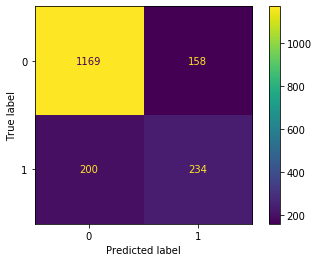

In [72]:
model_score(test_pred, train_pred, y_test, y_train)
plot_confusion_matrix(forest, X_test, y_test)

Very high training accuracy. Probably some very high overfitting going on here, especially since the validation is pretty low.
Both type I and type II errors are looking pretty similar in frequency, with a slight skew towards type II errors being more common. False positive

Take a look at what're the important variables with churn. Plot each of the vars with churn. 

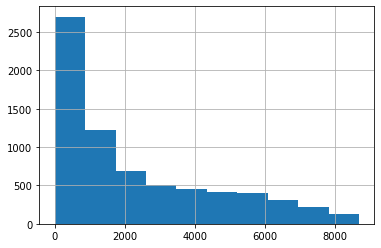

In [73]:
cont_feats['TotalCharges'].hist()

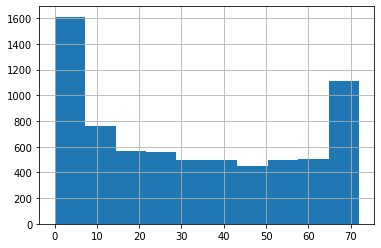

In [74]:
cont_feats['tenure'].hist()

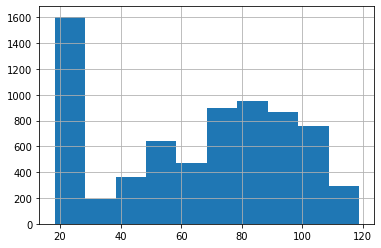

In [75]:
cont_feats['MonthlyCharges'].hist()

Text(0.5, 1.0, 'Internet Type')

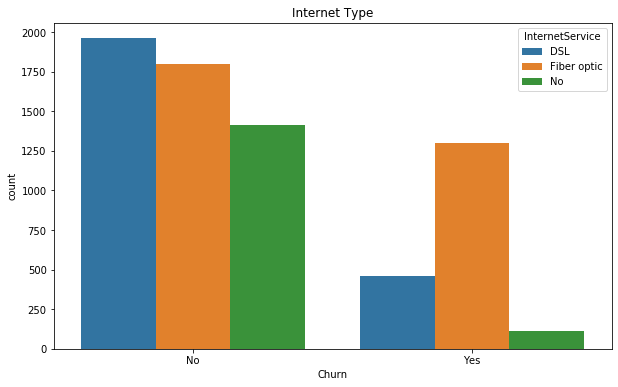

In [152]:
plt.figure(figsize=(10,6))
sns.countplot(x=df['Churn'], hue=features['InternetService']).set_title('Internet Type')

tenure
MonthlyCharges
TotalCharges


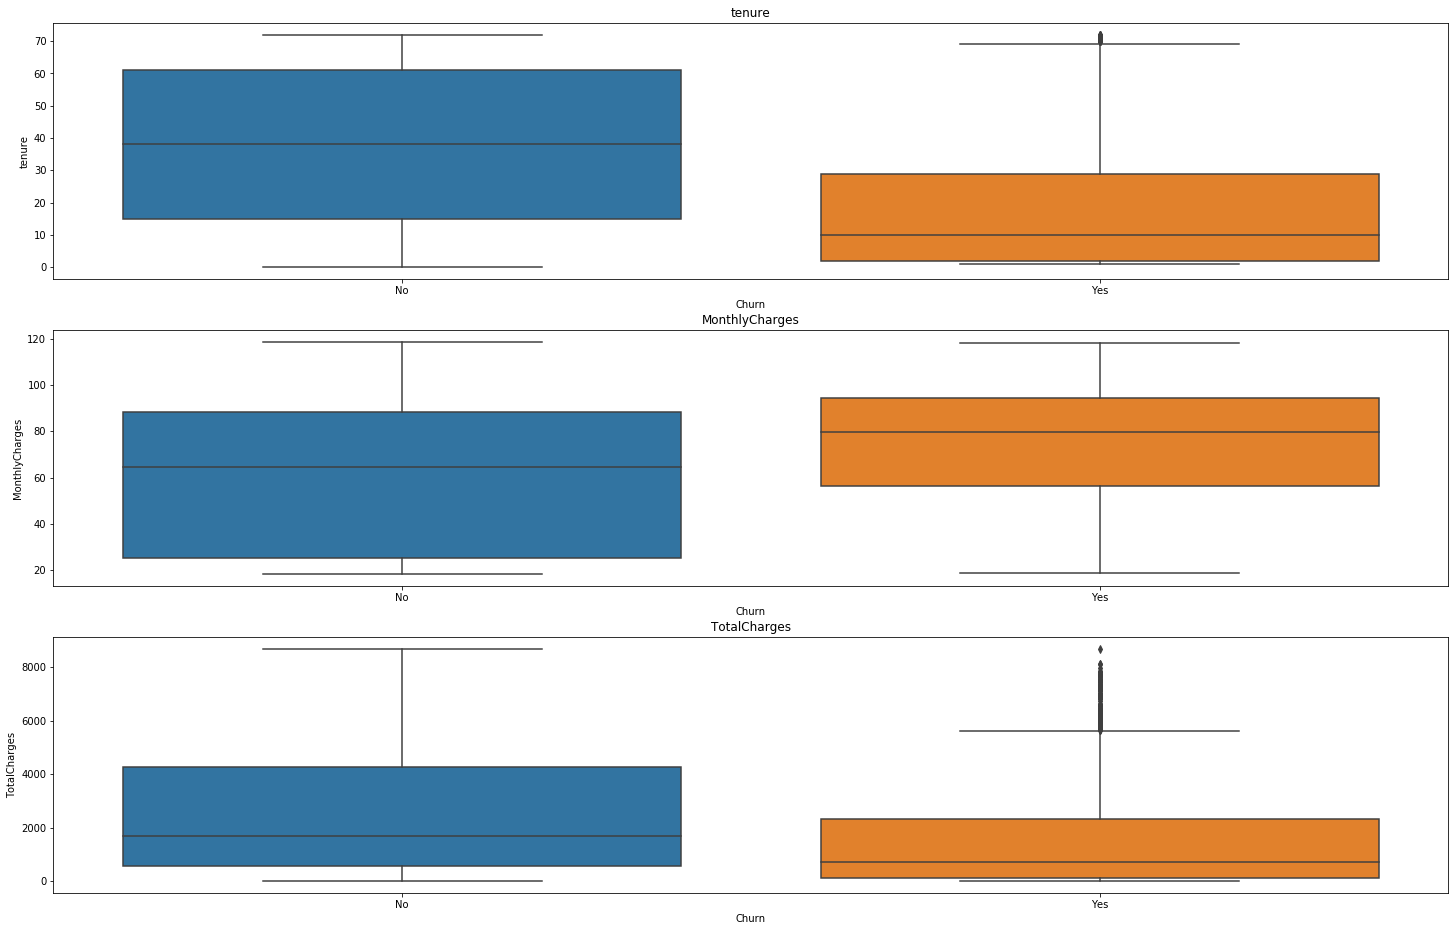

In [76]:
fig, axs = plt.subplots(nrows=3, figsize=(25,16))
n=0
for feat in cont_feats:
    sns.boxplot(x='Churn', y=feat, data = df , ax=axs[n]).set_title(feat)
    n+=1

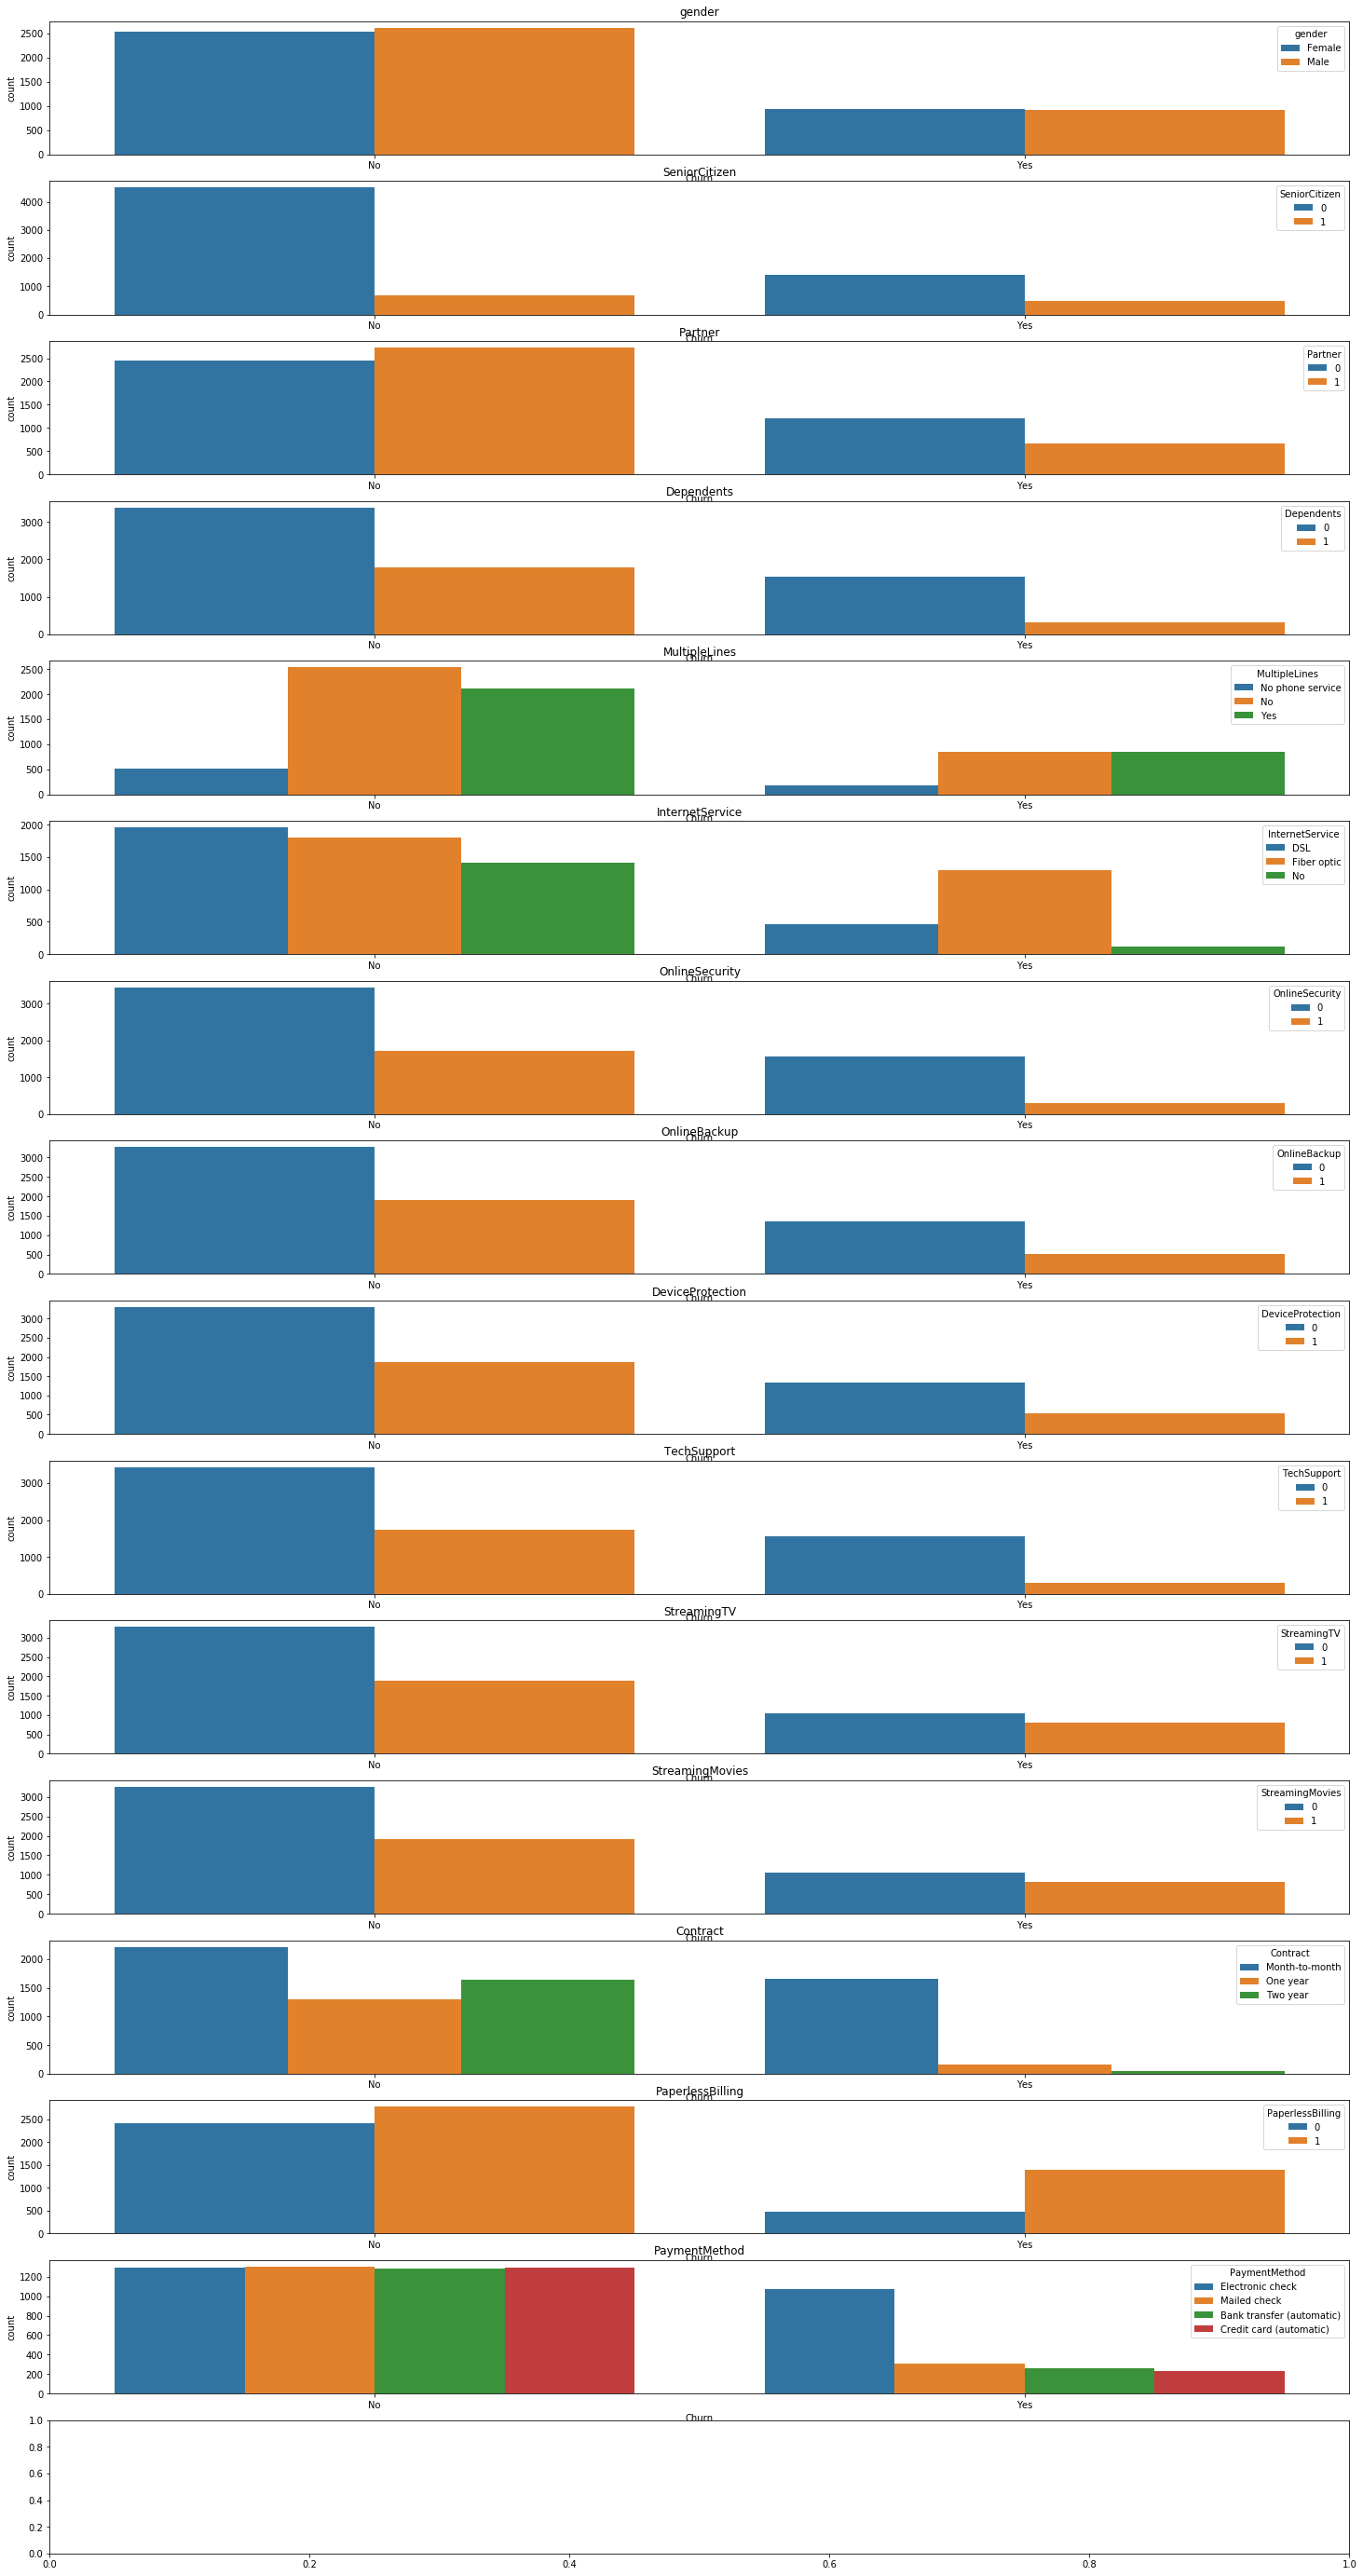

In [107]:
fig, axs = plt.subplots(nrows=16,figsize=(25,50))
n=0
for feat in cat_feats:
    sns.countplot(x=df['Churn'], hue=features[feat] , ax=axs[n]).set_title(feat)
    n+=1

Features that look important: partner, internet service, contract, paperless billing, and payment method

SMOTE

In [78]:
#resample the training set to be more balanced
X_resampled, y_resampled = SMOTE().fit_resample(df1, target) 

In [79]:
y_resampled.value_counts()

1    5174
0    5174
Name: Churn, dtype: int64

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.25, random_state=1)

Rerun the vanilla tree, but this time with the balanced sample sizes. 

In [81]:
forest = RandomForestClassifier(random_state=1)
forest.fit(X_train, y_train)
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)

Training Accuracy: 99.86%
Validation Accuracy: 85.5%
Training Precision: 99.85%
Validation Precision: 84.56%
Training Recall: 99.87%
Validation Recall: 85.84%
Training F1: 99.86%
Validation F1: 85.2%


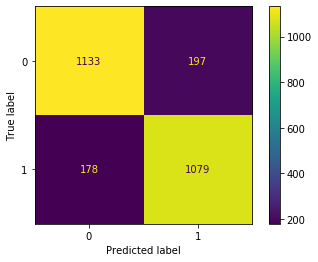

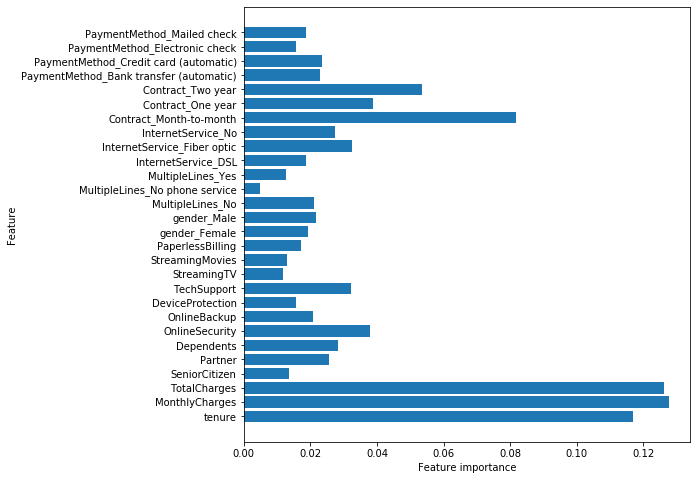

In [82]:
model_score(test_pred, train_pred, y_test, y_train)
plot_confusion_matrix(forest, X_test, y_test)
plot_feature_importances(forest)

So we've reduced the amount of overfitting. The model actually looks pretty decent but we'll tinker with a few of the parameters a bit more.

We'd rather catch more people who will be churning, so incorrectly categorizing those who aren't going to be churning as individuals that will is preferable.

Forgot to scale the features. Will do that here, and rerun the vanilla model one more time, using min-max scaling.

In [83]:
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)
X_train_scale = pd.DataFrame(X_train_scale, columns = X_train.columns)
X_test_scale = pd.DataFrame(X_test_scale, columns = X_test.columns)

In [84]:
#X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_scale, y_train) 

In [85]:
forest = RandomForestClassifier(random_state=1)
forest.fit(X_train_scale, y_train)
train_pred = forest.predict(X_train_scale)
test_pred = forest.predict(X_test_scale)

Training Accuracy: 99.86%
Validation Accuracy: 85.47%
Training Precision: 99.85%
Validation Precision: 84.44%
Training Recall: 99.87%
Validation Recall: 85.92%
Training F1: 99.86%
Validation F1: 85.17%


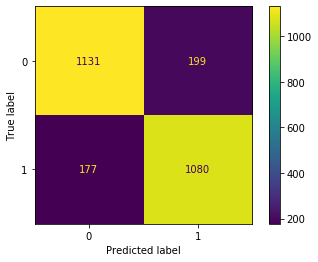

In [86]:
model_score(test_pred, train_pred, y_test, y_train)
plot_confusion_matrix(forest, X_test_scale, y_test)

OK So with the scaled features, the model is performing pretty much identically. 

In [87]:
X_train_scale.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Partner',
       'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'gender_Female', 'gender_Male', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

Now we're going to take a look at what're the important features.

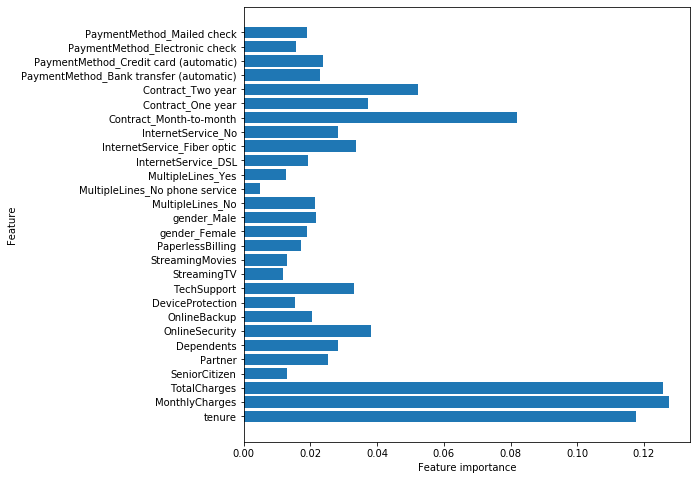

In [88]:
plot_feature_importances(forest)

The most important features here are the continous features, by a whole lot actually. This does make it seem that perhaps the scaling is a bit off or something. 
Features that looked important from the plots and have high importance on the plot are: internet service, contract, paperless billing, and payment method

In [37]:
param_grid_for = {'n_estimators': [10, 50, 100, 150],
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10, 15],
                'min_samples_split': [2, 4, 6, 8, 10],
                'min_samples_leaf': [1, 2, 3, 6, 8]}

In [562]:
#gridsearch with the scaled data
forest = RandomForestClassifier(random_state=1)
grid_for=GridSearchCV(forest, param_grid_for, cv = 5)
grid_for.fit(X_train_scale, y_train)
best_parameters = grid_for.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
criterion: 'entropy'
max_depth: 15
min_samples_leaf: 2
min_samples_split: 2
n_estimators: 150


In [564]:
#gridsearch with the not scaled data
forest = RandomForestClassifier(random_state=1)
grid_for2=GridSearchCV(forest, param_grid_for, cv = 5)
grid_for2.fit(X_train, y_train)
best_parameters = grid_for2.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
criterion: 'gini'
max_depth: 15
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 100


So we're going to try two different things here, the first being just using the parameters we've determined to be good. but also we're gonna try binning the continuous features.

Training Accuracy: 94.36%
Validation Accuracy: 84.96%
Training Precision: 93.0%
Validation Precision: 83.08%
Training Recall: 96.04%
Validation Recall: 86.71%
Training F1: 94.5%
Validation F1: 84.86%


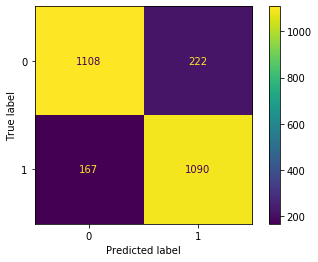

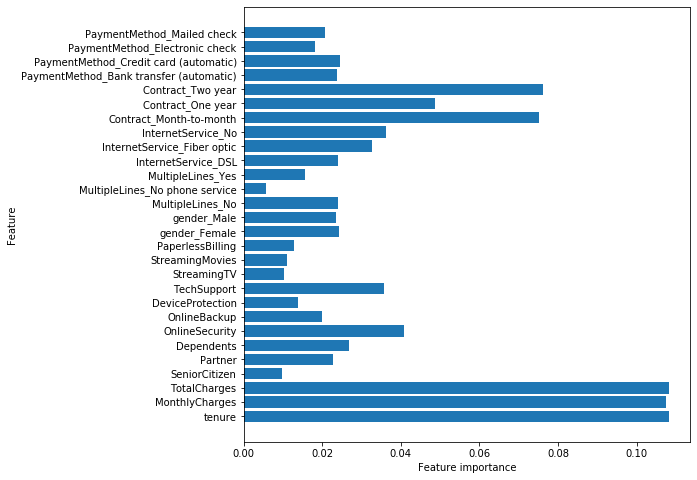

In [89]:
#scaled
forest = RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf = 2, min_samples_split = 2,
                                n_estimators=150, random_state=1)
forest.fit(X_train_scale, y_train)
train_pred = forest.predict(X_train_scale)
test_pred = forest.predict(X_test_scale)
model_score(test_pred, train_pred, y_test, y_train)
plot_confusion_matrix(forest, X_test_scale, y_test)
plot_feature_importances(forest)

Training Accuracy: 97.37%
Validation Accuracy: 85.39%
Training Precision: 95.2%
Validation Precision: 83.47%
Training Recall: 99.82%
Validation Recall: 87.19%
Training F1: 97.46%
Validation F1: 85.29%


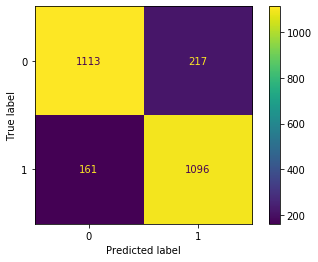

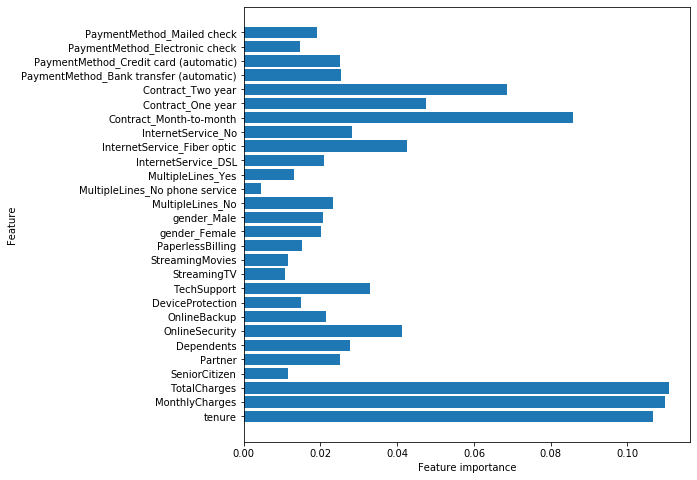

In [39]:
#notscaled
forest = RandomForestClassifier(criterion='gini', max_depth=15, min_samples_leaf = 1, min_samples_split = 2,
                                n_estimators=100, random_state=1)
forest.fit(X_train, y_train)
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)
model_score(test_pred, train_pred, y_test, y_train)
plot_confusion_matrix(forest, X_test, y_test)
plot_feature_importances(forest)

In [40]:
cont_feats.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [41]:
cont_feats['tenure'].quantile([.25, .75])

0.25     9.0
0.75    55.0
Name: tenure, dtype: float64

In [42]:
cont_feats['MonthlyCharges'].quantile([.25, .75])

0.25    35.50
0.75    89.85
Name: MonthlyCharges, dtype: float64

In [43]:
cont_feats['TotalCharges'].quantile([.25, .75])

0.25     398.55
0.75    3786.60
Name: TotalCharges, dtype: float64

In [93]:
cont_feats['MonthlyCharges'] = cont_feats['MonthlyCharges'].apply(lambda x: 'high' if x >= 89.85 else ('medium' if x >= 35.5 else 'low'))
cont_feats['tenure'] = cont_feats['tenure'].apply(lambda x: 'long' if x >= 55 else ('medium' if x >= 9 else 'short'))
cont_feats['TotalCharges'] = cont_feats['TotalCharges'].apply(lambda x: 'high' if x >= 3786.6 else ('medium' if x >= 398.55 else 'low'))
#short less than 9 months
#medium in the middle
#long greater than 55 months
#this seems kinda wonky actually, I think there's some play we can do here

In [108]:
cont_dummies = pd.get_dummies(cont_feats)
df2 = pd.concat([cont_dummies, features_dummies], axis=1)
X_resampled, y_resampled = SMOTE().fit_resample(df2, target) 

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.25, random_state=1)

In [109]:
y_train.value_counts()

1    3917
0    3844
Name: Churn, dtype: int64

In [110]:
#vanilla model with binned features
forest = RandomForestClassifier(random_state=1)
forest.fit(X_train, y_train)
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)

Training Accuracy: 95.12%
Validation Accuracy: 83.34%
Training Precision: 93.23%
Validation Precision: 80.37%
Training Recall: 97.4%
Validation Recall: 86.95%
Training F1: 95.27%
Validation F1: 83.53%


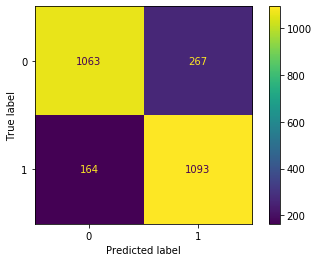

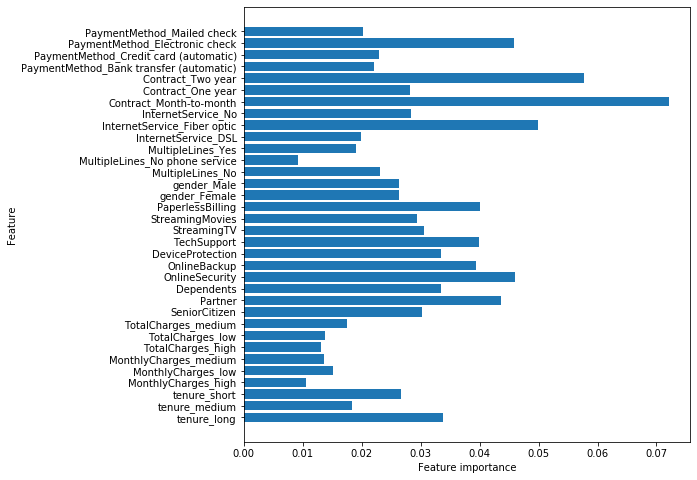

In [111]:
model_score(test_pred, train_pred, y_test, y_train)
plot_confusion_matrix(forest, X_test, y_test)
plot_feature_importances(forest)

Rerun this!! Unfortunately.

In [114]:
#gridsearch with the binned data
#forest = RandomForestClassifier(random_state=1)
#grid_for3=GridSearchCV(forest, param_grid_for, cv = 5)
#grid_for3.fit(X_train, y_train)
best_parameters = grid_for3.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
criterion: 'entropy'
max_depth: 15
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 150


Training Accuracy: 93.71%
Validation Accuracy: 83.26%
Training Precision: 90.46%
Validation Precision: 79.47%
Training Recall: 97.86%
Validation Recall: 88.39%
Training F1: 94.02%
Validation F1: 83.69%


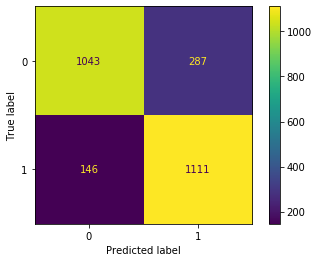

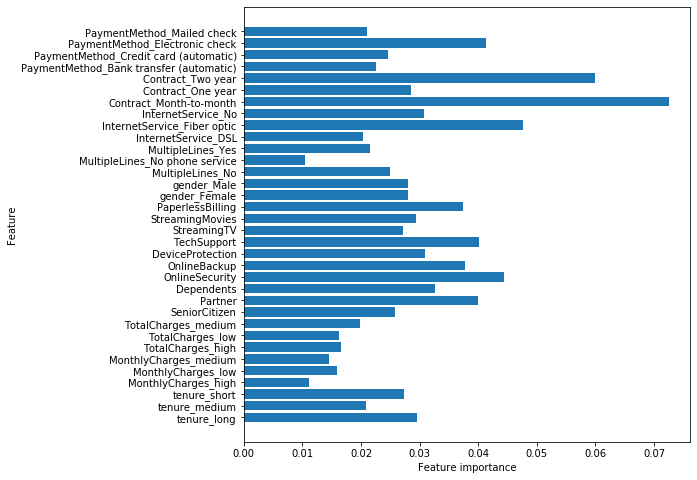

In [133]:
forest = RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf = 1, min_samples_split = 2,
                                n_estimators=150, random_state=1)
forest.fit(X_train, y_train)
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)
model_score(test_pred, train_pred, y_test, y_train)
plot_confusion_matrix(forest, X_test, y_test)
plot_feature_importances(forest)

In [125]:
from sklearn import tree

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

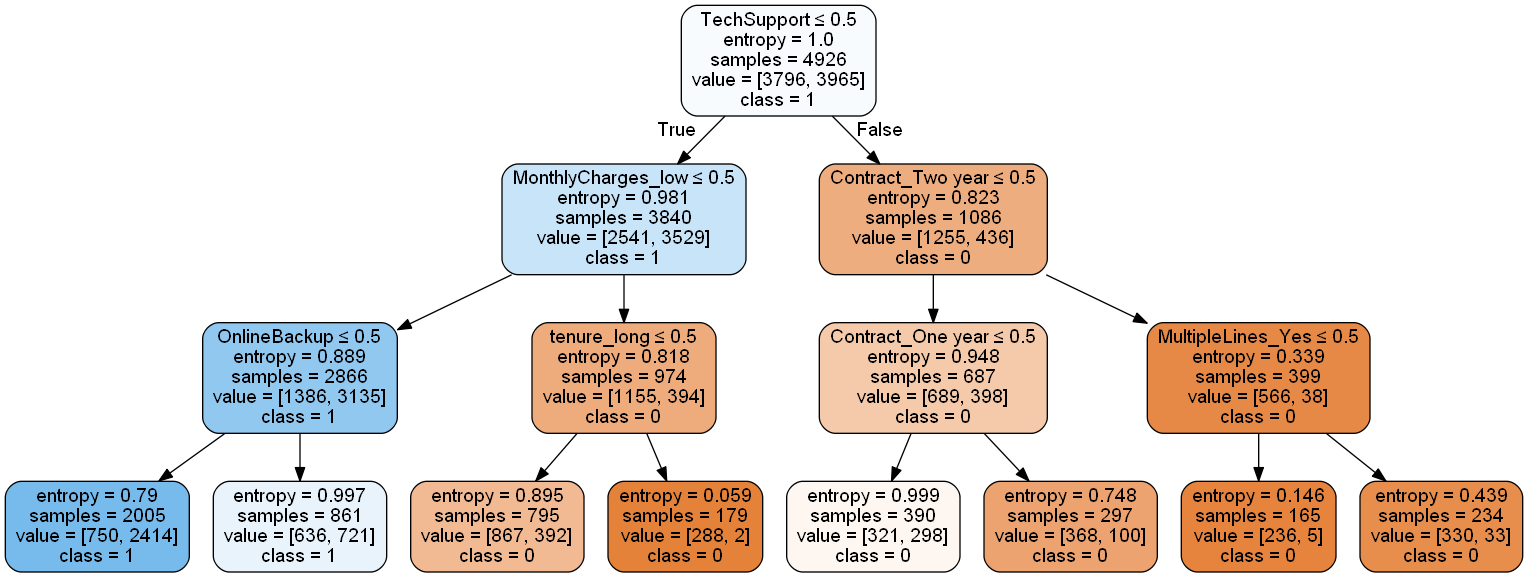

In [123]:
forest = RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_leaf = 1, min_samples_split = 2,
                                n_estimators=150, random_state=1)
forest.fit(X_train, y_train)
estimator = forest.estimators_[5]

col_names = X_train.columns
dot_data = StringIO()
export_graphviz(estimator, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = col_names,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('churn.png')
Image(graph.create_png())

We have 3 pretty good performing models here, and choosing which one is going to be the tricky part.
I think the binned tree model has the most promise, and also has some more parameter tuning that can be done on it. 

Important takeaways here:
contract type, how long they've been a customer, and how much they're paying are important. That being said, how much the customer engages with the product matters as well.
Looking at this tree, if a customer has medium to high monthly charges, and doesn't use the tech support option, it looks like its likely that they will churn. But on the other hand, customers that have one to two year contracts are much less likely to churn. 

Future work will include looking at how much money a customer would be expected to spend based on their account statistics, as well as adjusting the money bin sizes, and adjusting a few of the features such as techsupport and device protection into a new feature where its simply how engaged the customer is in using the products. 